In [1]:
# Install required packages
!pip install statannot
!pip install spectral
!pip install geoarray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 212 kB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 250 kB 5.3 MB/s 
     |████████████████████████████████| 10.8 MB 3.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 20.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 9.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 37.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error

In [2]:
# Import required library for the classification module
import io
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from google.colab import files
import seaborn as sns


In [3]:
# Define functions
import math
from scipy.signal import convolve2d

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


#-------------------------------------------------------------------------------
# Plot confusion matrix for classification result
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #if not title:
    #    if normalize:
    #        title = 'Normalized confusion matrix'
    #    else:
    #        title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(13.7, 11), frameon=True)
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=13)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor", fontsize=13)
    
    plt.setp(ax.set_xlabel('Predicted label', fontsize=16))

    plt.setp(ax.get_yticklabels(), rotation=0, ha="right",
             rotation_mode="anchor", fontsize=13)
    
    plt.setp(ax.set_ylabel('True label', fontsize=16))
    
    plt.setp(ax.set_title(title, fontsize=16))

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), size=12,
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


#-------------------------------------------------------------------------------
def print_cm(cm, labels):
    """pretty print for confusion matrix"""
    # https://gist.github.com/ClementC/acf8d5f21fd91c674808
    columnwidth = max([len(x) for x in labels])
    # Print header
    print(" " * columnwidth, end="\t")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end="\t")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("%{0}s".format(columnwidth) % label1, end="\t")
        for j in range(len(labels)):
            print("%{0}s".format(columnwidth) % round(cm[i, j], 3), end="\t")
        print()


#-------------------------------------------------------------------------------
# Export classification results to GeoTIFF
from osgeo import gdal,osr
import numpy as np

def save_raster(path, img, prj, geotran, format='GTiff', dtype = gdal.GDT_Float32):
    rows, cols = img.shape
    # Initialize driver & create file
    driver = gdal.GetDriverByName(format)
    dataset_out = driver.Create(path, cols, rows, 1, dtype)
    dataset_out.SetGeoTransform(geotran)
    dataset_out.SetProjection(prj)
    # Write file to disk
    dataset_out.GetRasterBand(1).WriteArray(img.real)
    dataset_out.FlushCache()
    dataset_out=None


#-------------------------------------------------------------------------------
def estimate_noise(I):
    # Ref: Fast Noise Variance Estimation
    H, W = I.shape
    M = [[1, -2, 1],
        [-2, 4, -2],
        [1, -2, 1]]
    
    sigma = np.sum(np.sum(np.absolute(convolve2d(I, M))))
    sigma = sigma * math.sqrt(0.5 * math.pi) / (6 * (W-2) * (H-2))
    return sigma


#-------------------------------------------------------------------------------
import skimage
def fix_small_segments(segments, window_size=15, max_iterations=5, min_size=1):
        # This skimage function assigns label "0" to small objects
        small_objs = skimage.morphology.remove_small_objects(segments,
                                                             min_size=min_size,
                                                             connectivity=1,
                                                             in_place=False
                                                             )
        small_objs_idxs = np.where(small_objs == 0)
        fixed_segments = np.copy(segments)
        iterations = 0
        while len(small_objs_idxs[0]) > 0 and iterations < max_iterations:
            w = int(window_size/2)
            for i, (row, col) in enumerate(zip(*small_objs_idxs)):
                r1 = max(0, row-w)
                c1 = max(0, col-w)
                r2 = min(segments.shape[0], row+w+1)
                c2 = min(segments.shape[1], col+w+1)
                block = fixed_segments[r1:r2, c1:c2]
                mode, _ = scipy.stats.mode(block[block > 0], axis=None)
                if len(mode) > 0 and mode[0] != 0:
                    fixed_segments[row, col] = mode[0]

            fixed_segments = skimage.morphology.remove_small_objects(
                fixed_segments, min_size=2, connectivity=1, in_place=False)
            small_objs_idxs = np.where(fixed_segments == 0)
            iterations += 1

        return fixed_segments


#-------------------------------------------------------------------------------
# Define the derivative calculation function
def derivative(f, x, method='central', interval=1):
    '''Compute the difference formula for f'(x) with step size interval.
    Parameters:
    -----------
    f: Function
       Vectorized function of one variable
       
    x: Compute derivative at wavelength x
       method: string - 'forward', 'backward' or 'central'
    
    interval: Step size in difference formula
    '''
    
    if method == 'central':
        return (f(x + interval) - f(x - interval))/(2*interval)
    elif method == 'forward':
        return (f(x + interval) - f(x))/interval
    elif method == 'backward':
        return (f(x) - f(x - interval))/interval
    else:
        raise ValueError("Method must be 'central', 'forward', or 'backward'.")


#-------------------------------------------------------------------------------
# Define a function to calculate mean spectra of each segment
# def label2rgb_avg(label_field, image, bg_label=0, bg_color=(0)):
def label2gray_avg(label_field, image, bg_label=0, bg_color=(0)):
    """Visualise each segment in `label_field` with its mean color in `image`.
    Parameters
    ----------
    label_field : ndarray of int
        A segmentation of an image.
    image : array, shape ``label_field.shape``
        A color image of the same spatial shape as `label_field`.
    bg_label : int, optional
        A value in `label_field` to be treated as background.
    bg_color : 3-tuple of int, optional
        The color for the background label
    Returns
    -------
    out : ndarray, same shape and type as `image`
        The output visualization.
    """
    out = np.zeros(label_field.shape, dtype=image.dtype)
    labels = np.unique(label_field)
    bg = (labels == bg_label)
    if bg.any():
        labels = labels[labels != bg_label]
        mask = (label_field == bg_label).nonzero()
        out[mask] = bg_color
    for label in labels:
        mask = (label_field == label).nonzero()
        color = image[mask].mean(axis=0)
        out[mask] = color
    return out

In [4]:
import os
from pathlib import Path
from google.colab import drive
drive.mount('/content/gdrive')

# Setup working directory
in_dir = Path('/content/gdrive/My Drive/Colab Notebooks/Species_classification_Eliceo/inputs')
out_dir = Path('/content/gdrive/My Drive/Colab Notebooks/Species_classification_Eliceo/results')


Mounted at /content/gdrive


In [5]:
# Read reflectance data
import joblib
import pickle
plt.style.use('seaborn-ticks')

ref_data_ori = pd.read_csv(in_dir/'species_spec_all.csv')
ref_data = (ref_data_ori.iloc[:, 0:262]).sort_values(by=['Species_CommonName'], ascending=True)
print("The number of training samples in each class")
print(ref_data_ori['Species_CommonName'].value_counts())

# Prepare input data for ML model training
species_name = encode_text_index(ref_data, 'Species_CommonName')
x_ml = (ref_data.iloc[:, 11:262])/10000
y_ml = ref_data['Species_CommonName']

# Smooth spectra data
x_ml = pd.DataFrame(savgol_filter(x_ml, window_length=9, polyorder=2, mode='interp', axis=1),
                    columns=x_ml.columns, index=x_ml.index)

# Extract column names
col_name = list(ref_data.iloc[:, 11:262].columns)
wavelength = []
for band in col_name:
  wavelength.append(float(band[1:]))

# Scale the data and split the training and test samples
x_ml_train, x_ml_test, y_ml_train, y_ml_test = train_test_split(x_ml, y_ml, test_size = 0.25, random_state = 42, stratify = y_ml)
# x_train, x_test, y_ml_train, y_ml_test = train_test_split(x_ml, y_ml, test_size = 0.25, random_state = 42, stratify = y_ml)
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaler.fit(x_train)
# x_ml_train = scaler.transform(x_train)
# x_ml_test = scaler.transform(x_test)

# Save the scaler to a file for future use
# pickle.dump(scaler, open(out_dir/'scaler.pkl', 'wb'))

# Calculate the mean spectral curves
ref_mean = ref_data.groupby("Species_CommonName").mean()

# Plot the mean spectra
plt_ref_mean = (ref_mean.iloc[:, 2:410].values).transpose()
plt_ref_mean = pd.DataFrame(plt_ref_mean, index=wavelength)
plt_ref_mean.plot(figsize=(9, 10), color=sns.set_palette("husl", 10))
plt.title("Mean Species Spectra", fontsize=16)
plt.xlabel('Wavelength (nm)', fontsize=16)
plt.ylabel('Reflectance', fontsize=16)
plt.grid(color='grey', linestyle='dotted', linewidth=0.55)
plt.tick_params(direction = 'in', color='black')
plt.xticks(fontsize=14)
plt.xlim(min(wavelength), max(wavelength))
plt.ylim(0, 10000)
plt.yticks(fontsize=14, rotation=90)
plt.legend(loc='upper right', frameon=False, fontsize=14,
           labels = list(species_name), ncol=3)
plt.savefig(out_dir/'Mean_spectra.png', dpi=300)


The number of training samples in each class
Sugar maple        145
Trembling aspen    144
Red pine            90
Bigtooth aspen      78
Red maple           73
Paper birch         54
White pine          50
Basswood            40
Black ash           34
White ash           33
Hemlock             30
Jack pine           28
Red oak             27
Alder               24
Black spruce        22
Tamarack            22
White cedar         21
White spruce        18
Black cherry        14
Ironwood             9
Yellow birch         7
Mixed grass          7
Name: Species_CommonName, dtype: int64


In [13]:
ref_data_ori.iloc[0,3]

'Red maple'

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


The best parameters are {'solver': 'lbfgs', 'n_iter_no_change': 20, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (300, 300), 'alpha': 0.001, 'activation': 'tanh'} with a score of 0.685
The best MLP model:
MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(300, 300),
              learning_rate='adaptive', max_iter=1000, n_iter_no_change=20,
              solver='lbfgs')
(+0.553/-0.064) for {'solver': 'adam', 'n_iter_no_change': 20, 'learning_rate': 'constant', 'hidden_layer_sizes': (200, 200), 'alpha': 0.0001, 'activation': 'tanh'}
(+0.670/-0.040) for {'solver': 'lbfgs', 'n_iter_no_change': 20, 'learning_rate': 'constant', 'hidden_layer_sizes': (50, 50), 'alpha': 0.001, 'activation': 'identity'}
(+0.620/-0.029) for {'solver': 'lbfgs', 'n_iter_no_change': 20, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50, 50), 'alpha': 0.0001, 'activation': 'relu'}
(+0.325/-0.031) for {'solver': 'sgd', 'n_iter_no_change': 20, 'learning_rate': 'adaptive', 'hidden_layer_sizes

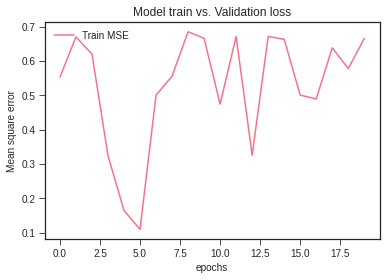

Processing time: 2023.973 Secs


In [ ]:
# Multilayer perceptron deep (MLP) neural network classification
# From skopt import BayesSearchCV
import joblib
import pickle
import time
from sklearn.neural_network import MLPClassifier
plt.style.use('seaborn-ticks')

start_time = time.time()

# Setup parameters for MLP model tuning
'''Parameters need to be tuned:
- Alpha: learning rate is the most important parameter
- Number of hidden units: the second most important parameter
- Number of layers: the third most important parameter
- Beta: momentum term, usually 0.9
- Learning rate decay
- Mini batch size
- Beta1=0.9, Beta2=0.99, and epsilon = 1e-8 for Adam optimization does not need to be tuned'''

mlp_parameters = {
    'hidden_layer_sizes': [(300,300), (300,50), (200,200), (100,100), (50,50)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.00001, 0.0001, 0.001],
    'learning_rate': ['constant','adaptive', 'invscaling'],
    #'batch_size': [200, 300, 400, 500, 600, 700],
    'n_iter_no_change': [20]
}

mlp_grid = RandomizedSearchCV(estimator = MLPClassifier(max_iter=1000),
                              param_distributions=mlp_parameters, cv=5,
                              n_iter=20, verbose=1, n_jobs=-1)

# mlp_grid = GridSearchCV(estimator = MLPClassifier(max_iter=100),
#                        param_grid=mlp_parameters, cv=5, n_jobs=-1)

mlp_grid.fit(x_ml_train, y_ml_train)

# Print the tuning result and get the best parameters
print("The best parameters are %s with a score of %0.3f"
      % (mlp_grid.best_params_, mlp_grid.best_score_))

print("The best MLP model:")
print(mlp_grid.best_estimator_)

# Print the trainng results
mlp_means = mlp_grid.cv_results_['mean_test_score']
mlp_stds = mlp_grid.cv_results_['std_test_score']
for mean, std, params in zip(mlp_means, mlp_stds, mlp_grid.cv_results_['params']):
    print("(+%0.3f/-%0.03f) for %r"% (mean, std * 2, params))

#Plot the training result graph
#plt.plot(mlp_grid.cv_results_['mean_train_score'])
plt.plot(mlp_grid.cv_results_['mean_test_score'])
plt.title('Model train vs. Validation loss')
plt.xlabel('epochs')
plt.ylabel('Mean square error')
plt.legend(['Train MSE', 'validation MSE'], loc='upper left')
plt.show()

# Save the trained MLP model as a pickle file
path_mlp = out_dir/'mlp_model.pkl' 
joblib.dump(mlp_grid, open(path_mlp, 'wb'))

# Calculate training time
end_time = time.time()
elapsed_time = (end_time - start_time)
print("Processing time:", round(elapsed_time,3), "Secs")


Overall Accuracy: 81.481
kapa Cofficient: 0.798
Normalized confusion matrix
[[0.83 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.17 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.8  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.1  0.   0.
  0.   0.   0.   0.1  0.   0.   0.   0.  ]
 [0.   0.   0.55 0.   0.05 0.   0.   0.   0.   0.   0.1  0.   0.   0.
  0.   0.   0.3  0.   0.   0.   0.   0.  ]
 [0.   0.11 0.   0.78 0.   0.   0.   0.   0.   0.   0.   0.11 0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.4  0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.6  0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.62 0.   0.   0.   0.   0.   0.   0.
  0.25 0.   0.   0.   0.   0.   0.12 0.  ]
 [0.   0.   0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.5  0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0. 

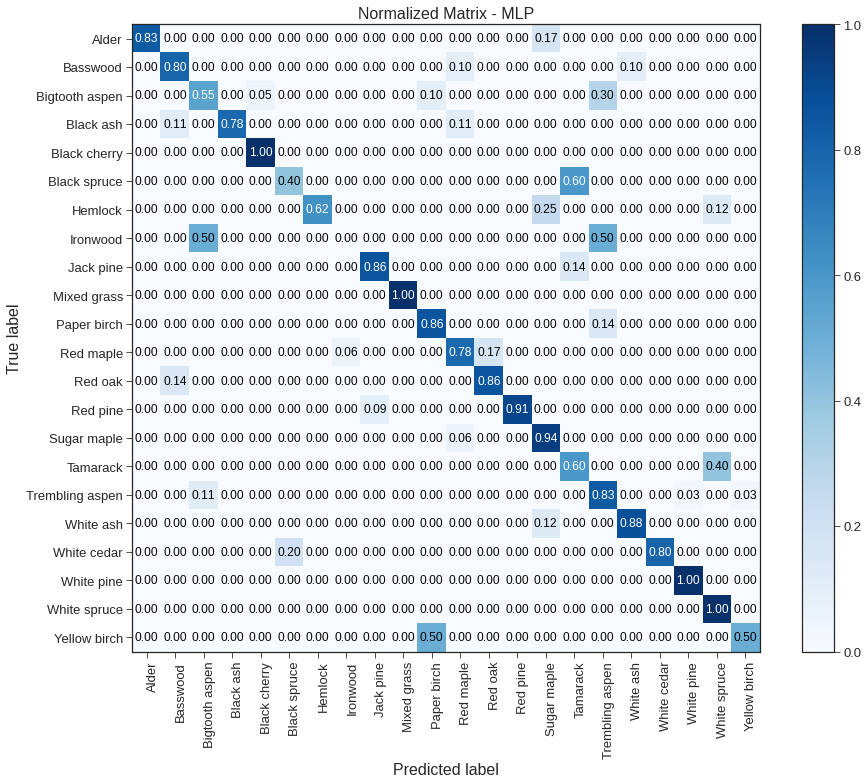

----------------------------------------------------------------------------------------------------------------------------
Confusion matrix:
               	          Alder	       Basswood	 Bigtooth aspen	      Black ash	   Black cherry	   Black spruce	        Hemlock	       Ironwood	      Jack pine	    Mixed grass	    Paper birch	      Red maple	        Red oak	       Red pine	    Sugar maple	       Tamarack	Trembling aspen	      White ash	    White cedar	     White pine	   White spruce	   Yellow birch	
          Alder	              5	              0	              0	              0	              0	              0	              0	              0	              0	              0	              0	              0	              0	              0	              1	              0	              0	              0	              0	              0	              0	              0	
       Basswood	              0	              8	              0	              0	              0	              0	       

In [ ]:
# Load the model and perform MLP classification
import pickle
import joblib
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
plt.style.use('seaborn-ticks')

# Load the pickled model
path_mlp = out_dir/'mlp_model.pkl'
mlp_classifier =  joblib.load(open(path_mlp, 'rb'))

y_ml_pred = mlp_classifier.predict(x_ml_test)

kappa_mlp = cohen_kappa_score(y_ml_test, y_ml_pred)
Overall_acc = accuracy_score(y_ml_test, y_ml_pred)
print('Overall Accuracy:', round(Overall_acc*100, 3))
print('kapa Cofficient:', round(kappa_mlp,3))

# Plot normalized confusion matrix
np.set_printoptions(precision=2)
plot_confusion_matrix(y_ml_test, y_ml_pred, classes=species_name, normalize=True,
                      title='Normalized Matrix - MLP')
plt.savefig(out_dir/'mlp_confusion_matrix.png', dpi=300)
plt.show()

# Save runtime and accuracy a text file
with open(out_dir/'mlp_model_accuracy.txt', 'w', newline='') as txtfile:
  txtfile.write('Overall Accuracy: ' + str(round(Overall_acc*100, 3)) + '\n')
  txtfile.write('Kappa Coefficient: ' + str(round(kappa_mlp, 3))+ '\n')


# Print confusion matrix and accuracy assessment details
print('----------------------------------------------------------------------------------------------------------------------------')
print('Confusion matrix:')
cm = metrics.confusion_matrix(y_ml_test, y_ml_pred, normalize=None)
print_cm(cm, species_name)

print()
print('----------------------------------------------------------------------------------------------------------------------------')
print("Classification accuracy report:\n%s" %
      metrics.classification_report(y_ml_test, y_ml_pred, digits=3,
                                    target_names=species_name))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
The best parameters are {'kernel': 'linear', 'gamma': 'scale', 'degree': 1, 'C': 100.0} with a score of 0.564
The best SVM model:
SVC(C=100.0, degree=1, kernel='linear', max_iter=1000)
0.457 (+/-0.050) for {'kernel': 'linear', 'gamma': 'scale', 'degree': 1, 'C': 10.0}
0.457 (+/-0.050) for {'kernel': 'linear', 'gamma': 'scale', 'degree': 2, 'C': 10.0}
0.326 (+/-0.028) for {'kernel': 'poly', 'gamma': 'scale', 'degree': 2, 'C': 0.1}
0.325 (+/-0.028) for {'kernel': 'linear', 'gamma': 'scale', 'degree': 2, 'C': 0.1}
0.312 (+/-0.025) for {'kernel': 'poly', 'gamma': 'scale', 'degree': 1, 'C': 0.1}
0.265 (+/-0.047) for {'kernel': 'rbf', 'gamma': 'auto', 'degree': 1, 'C': 1.0}
0.457 (+/-0.050) for {'kernel': 'linear', 'gamma': 'auto', 'degree': 2, 'C': 10.0}
0.457 (+/-0.050) for {'kernel': 'linear', 'gamma': 'auto', 'degree': 1, 'C': 10.0}
0.314 (+/-0.042) for {'kernel': 'poly', 'gamma': 'auto', 'degree': 2, 'C': 10.0}
0.334 (+/-0.02

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


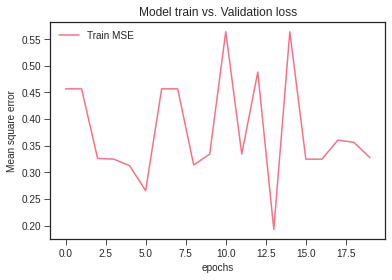

Processing time: 9.462 Secs


In [ ]:
# SVM classification model tuning using RandomizedSearchCV
import joblib
import pickle
import time
from sklearn import svm
plt.style.use('seaborn-ticks')

start_time = time.time()

# Setup SVM model Parameters for tuning
svm_parameters = {'kernel': ['rbf', 'poly', 'linear'],
                  'degree': [1, 2],
                  'C': [1e-1, 1e+0, 1e+1, 1e+2],
                  # 'gamma': [1e-3, 1e-2, 1e-1]
                  'gamma': ['scale', 'auto']
                  }

svm_grid = RandomizedSearchCV(svm.SVC(max_iter=1000),
                              param_distributions=svm_parameters, cv=5,
                              n_iter=20, verbose=1, n_jobs=-1)

# svm_grid = GridSearchCV(estimator = svm.SVC(max_iter=100),
#                         param_grid=svm_parameters, cv=5, n_jobs=-1)

svm_grid.fit(x_ml_train, y_ml_train)

# Print the tuning result and get the best parameters
print("The best parameters are %s with a score of %0.3f"
      % (svm_grid.best_params_, svm_grid.best_score_))

print("The best SVM model:")
print(svm_grid.best_estimator_)

means = svm_grid.cv_results_['mean_test_score']
stds = svm_grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, svm_grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"% (mean, std*2, params))

#Plot the training results
#plt.plot(mlp_grid.cv_results_['mean_train_score'])
plt.plot(svm_grid.cv_results_['mean_test_score'])
plt.title('Model train vs. Validation loss')
plt.xlabel('epochs')
plt.ylabel('Mean square error')
plt.legend(['Train MSE', 'validation MSE'], loc='upper left')
plt.show()

# Save the trained SVM model as a pickle file
path_svm = out_dir/'svm_model.pkl'
joblib.dump(svm_grid, open(path_svm, 'wb'))

# Calculate training time
end_time = time.time()
elapsed_time = (end_time - start_time)
print("Processing time:", round(elapsed_time,3), "Secs")


Overall Accuracy: 61.728
Kappa Coefficient: 0.58
Normalized confusion matrix
[[0.83 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.17 0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.4  0.   0.   0.   0.   0.1  0.   0.   0.   0.1  0.1  0.   0.
  0.2  0.   0.1  0.   0.   0.   0.   0.  ]
 [0.   0.   0.8  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.2  0.   0.   0.   0.   0.  ]
 [0.   0.11 0.11 0.67 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.11 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.33 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.67 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.38 0.   0.   0.   0.   0.12 0.   0.
  0.25 0.   0.12 0.   0.12 0.   0.   0.  ]
 [0.   0.   0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.5  0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.

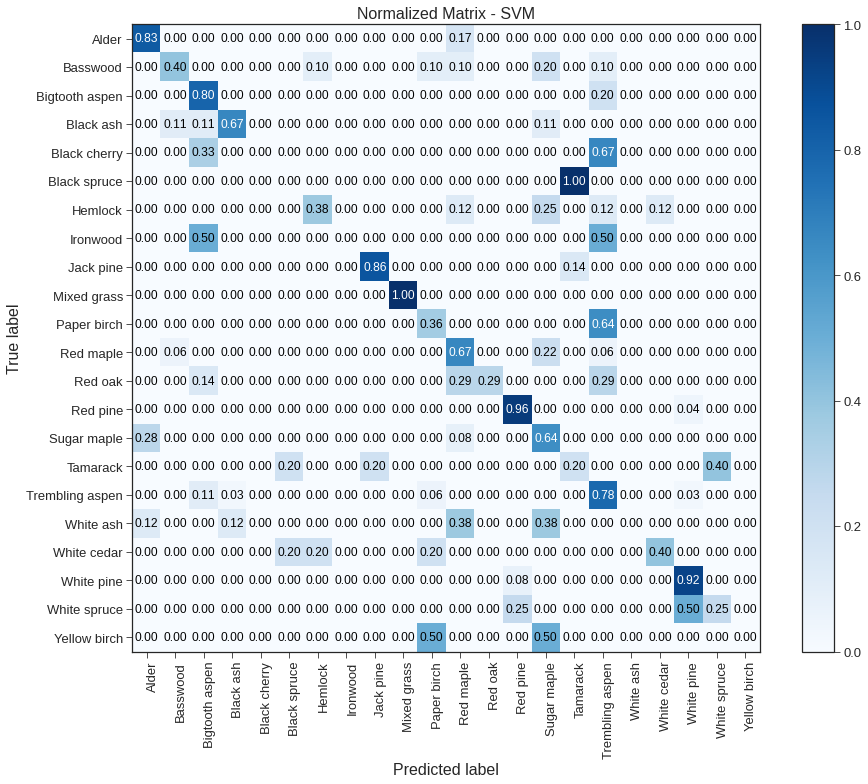

----------------------------------------------------------------------------------------------------------------------------
Confusion matrix:
               	          Alder	       Basswood	 Bigtooth aspen	      Black ash	   Black cherry	   Black spruce	        Hemlock	       Ironwood	      Jack pine	    Mixed grass	    Paper birch	      Red maple	        Red oak	       Red pine	    Sugar maple	       Tamarack	Trembling aspen	      White ash	    White cedar	     White pine	   White spruce	   Yellow birch	
          Alder	              5	              0	              0	              0	              0	              0	              0	              0	              0	              0	              0	              1	              0	              0	              0	              0	              0	              0	              0	              0	              0	              0	
       Basswood	              0	              4	              0	              0	              0	              0	       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Load the model and perform SVM classification
import pickle
import joblib
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
plt.style.use('seaborn-ticks')

# Load the pickled model
path_svm = out_dir/'svm_model.pkl'
svm_classifier =  joblib.load(open(path_svm, 'rb'))
#svm_classifier = svm_grid.best_estimator_

y_svm_pred = svm_classifier.predict(x_ml_test)

kappa_svm = cohen_kappa_score(y_ml_test, y_svm_pred)
Overall_acc = accuracy_score(y_ml_test, y_svm_pred)
print('Overall Accuracy:', round(Overall_acc*100, 3))
print('Kappa Coefficient:', round(kappa_svm, 3))

#Plot normalized confusion matrix
np.set_printoptions(precision=2)
plot_confusion_matrix(y_ml_test, y_svm_pred, classes=species_name, normalize=True,
                      title='Normalized Matrix - SVM')
plt.savefig(out_dir/'svm_confusion_matrix.png', dpi=300)
plt.show()

# Save runtime and accuracy a text file
with open(out_dir/'svm_model_accuracy.txt', 'w', newline='') as txtfile:
  txtfile.write('Overall Accuracy: ' + str(round(Overall_acc*100, 3)) + '\n')
  txtfile.write('Kappa Coefficient: ' + str(round(kappa_svm, 3)) + '\n')


# Print confusion matrix and accuracy assessment details
print('----------------------------------------------------------------------------------------------------------------------------')
print('Confusion matrix:')
cm = metrics.confusion_matrix(y_ml_test, y_svm_pred, normalize=None)
print_cm(cm, species_name)

print()
print('----------------------------------------------------------------------------------------------------------------------------')
print("Classification accuracy report:\n%s" %
      metrics.classification_report(y_ml_test, y_svm_pred, digits=3,
                                    target_names=species_name))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/par

The best parameters are {'n_estimators': 50, 'max_features': 'auto', 'max_depth': 90, 'bootstrap': True} with a score of 0.670
The best RandomForest model:
RandomForestClassifier(max_depth=90, n_estimators=50)
Score = nan for {'n_estimators': 170, 'max_features': 'None', 'max_depth': 20, 'bootstrap': False}
Score = 0.663 for {'n_estimators': 110, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}
Score = nan for {'n_estimators': 50, 'max_features': 'None', 'max_depth': 80, 'bootstrap': True}
Score = 0.667 for {'n_estimators': 70, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': True}
Score = 0.667 for {'n_estimators': 90, 'max_features': 'log2', 'max_depth': 60, 'bootstrap': True}
Score = 0.664 for {'n_estimators': 70, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}
Score = 0.658 for {'n_estimators': 190, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}
Score = 0.663 for {'n_estimators': 70, 'max_features': 'auto', 'max_depth': None, 'bootstra

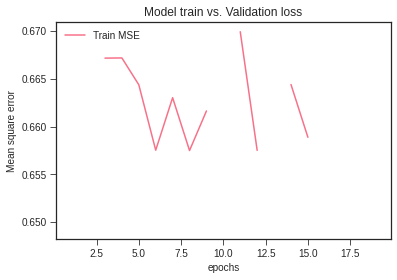

Processing time: 42.711 Secs


In [ ]:
# RandomForest classification model tuning using RandomizedSearchCV
import joblib
import pickle
import time
from sklearn.ensemble import RandomForestClassifier
plt.style.use('seaborn-ticks')

start_time = time.time()

# Setup Random Forest parameters for tuning
n_estimators = list(np.arange(10,220,20))
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
rfr_parameters = {'n_estimators': n_estimators,
                  'max_features': ['auto', 'sqrt', 'log2', 'None'],
                  'max_depth': max_depth,
                  #'min_samples_split': [2, 5, 10],
                  #'min_samples_leaf': [1, 2, 4],
                  'bootstrap': [True, False]}

rfr_grid = RandomizedSearchCV(RandomForestClassifier(),
                              param_distributions = rfr_parameters, cv=5,
                              n_iter=20, verbose=1, n_jobs=-1)

# rfr_grid = GridSearchCV(estimator = RandomForestClassifier(),
                        # param_grid=rfr_parameters, cv=5, n_jobs=-1)

# Fit the random search model for the grid search
rfr_grid.fit(x_ml_train, y_ml_train)

# Print the tuning result and get the best parameters
print("The best parameters are %s with a score of %0.3f"
      % (rfr_grid.best_params_, rfr_grid.best_score_))

print("The best RandomForest model:")
print(rfr_grid.best_estimator_)

means = rfr_grid.cv_results_['mean_test_score']
for mean, params in zip(means, rfr_grid.cv_results_['params']):
    print("Score = %0.3f for %r"% (mean, params))

#Plot the training results
#plt.plot(mlp_grid.cv_results_['mean_train_score'])
plt.plot(rfr_grid.cv_results_['mean_test_score'])
plt.title('Model train vs. Validation loss')
plt.xlabel('epochs')
plt.ylabel('Mean square error')
plt.legend(['Train MSE', 'validation MSE'], loc='upper left')
plt.show()

# Save the trained SVM model as a pickle file
path_rfr = out_dir/'rfr_model.pkl'
joblib.dump(rfr_grid, open(path_rfr, 'wb'))

# Calculate training time
end_time = time.time()
elapsed_time = (end_time - start_time)
print("Processing time:", round(elapsed_time,3), "Secs")


In [ ]:
# Load the model and perform RFR classification
import pickle
import joblib
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
plt.style.use('seaborn-ticks')

# Load the pickled model
path_rfr = out_dir/'rfr_model.pkl'
rfr_classifier =  joblib.load(open(path_rfr, 'rb'))
#rfr_classifier = rfr_grid.best_estimator_

y_rfr_pred = rfr_classifier.predict(x_ml_test)

kappa_rfr = cohen_kappa_score(y_ml_test, y_rfr_pred)
Overall_acc = accuracy_score(y_ml_test, y_rfr_pred)
print('Overall Accuracy:', round(Overall_acc*100, 3))
print('Kappa Coefficient:', round(kappa_rfr, 3))

#Plot normalized confusion matrix
np.set_printoptions(precision=2)
plot_confusion_matrix(y_ml_test, y_rfr_pred, classes=species_name, normalize=True,
                      title='Normalized Matrix - RF')
plt.savefig(out_dir/'rfr_confusion_matrix.png', dpi=300)
plt.show()

# Save runtime and accuracy a text file
with open(out_dir/'rfr_model_accuracy.txt', 'w', newline='') as txtfile:
  txtfile.write('Overall Accuracy: ' + str(round(Overall_acc*100, 3)) + '\n')
  txtfile.write('Kappa Coefficient: ' + str(round(kappa_rfr, 3)) + '\n')


# Print confusion matrix and accuracy assessment details
print('----------------------------------------------------------------------------------------------------------------------------')
print('Confusion matrix:')
cm = metrics.confusion_matrix(y_ml_test, y_rfr_pred, normalize=None)
print_cm(cm, species_name)

print()
print('----------------------------------------------------------------------------------------------------------------------------')
print("Classification accuracy report:\n%s" %
      metrics.classification_report(y_ml_test, y_rfr_pred, digits=3,
                                    target_names=species_name))

Overall Accuracy: 79.012
Kappa Coefficient: 0.771
Normalized confusion matrix
[[0.83 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.17 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.6  0.   0.   0.   0.   0.   0.   0.   0.   0.1  0.   0.   0.
  0.2  0.   0.   0.1  0.   0.   0.   0.  ]
 [0.   0.   0.65 0.   0.   0.   0.   0.   0.   0.   0.15 0.   0.   0.
  0.   0.   0.2  0.   0.   0.   0.   0.  ]
 [0.   0.11 0.   0.78 0.   0.   0.   0.   0.   0.   0.11 0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.8  0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.2  0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.5  0.   0.   0.   0.   0.25 0.   0.
  0.   0.   0.12 0.   0.12 0.   0.   0.  ]
 [0.   0.   0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.5  0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0

----------------------------------------------------------------------------------------------------------------------------
Confusion matrix:
               	          Alder	       Basswood	 Bigtooth aspen	      Black ash	   Black cherry	   Black spruce	        Hemlock	       Ironwood	      Jack pine	    Mixed grass	    Paper birch	      Red maple	        Red oak	       Red pine	    Sugar maple	       Tamarack	Trembling aspen	      White ash	    White cedar	     White pine	   White spruce	   Yellow birch	
          Alder	              5	              0	              0	              0	              0	              0	              0	              0	              0	              0	              0	              0	              0	              0	              1	              0	              0	              0	              0	              0	              0	              0	
       Basswood	              0	              6	              0	              0	              0	              0	       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


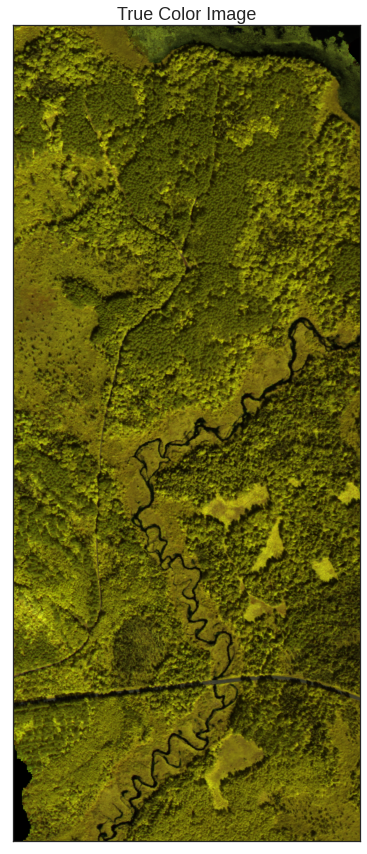

In [ ]:
# Read origial raster dataset and stack image bands
from skimage import exposure
from osgeo import gdal
plt.style.use('seaborn-ticks')

img_fn = in_dir/'CHEESEHEAD_20190830_11_clipped.tif'

raster_dataset = gdal.Open(str(img_fn), gdal.GA_ReadOnly)
geo_transform = raster_dataset.GetGeoTransform()
proj = raster_dataset.GetProjectionRef()
n_bands = raster_dataset.RasterCount

hsi_img = np.moveaxis(raster_dataset.ReadAsArray()[:251], 0, -1)
hsi_img = savgol_filter(hsi_img, window_length=9, polyorder=2, mode='interp', axis=-1) #.astype(np.uint16)
# hsi_img = np.ma.masked_array(hsi_img, mask=(hsi_img > 100))
# hsi_img = np.ma.masked_array(hsi_img, mask=(hsi_img < 50))

# Display RGB image
rgb_img = np.dstack([hsi_img[:, :, 180], hsi_img[:, :, 120], hsi_img[:, :, 55]])

plt.figure(figsize=(15, 15))
rgb_img = exposure.rescale_intensity(rgb_img, out_range=(0,1))
plt.title("True Color Image", fontsize=18)
plt.imshow(rgb_img, alpha=1)
plt.xticks(ticks=[], labels=None)
plt.yticks(ticks=[], labels=None)
plt.grid(b=None)
plt.show()


3


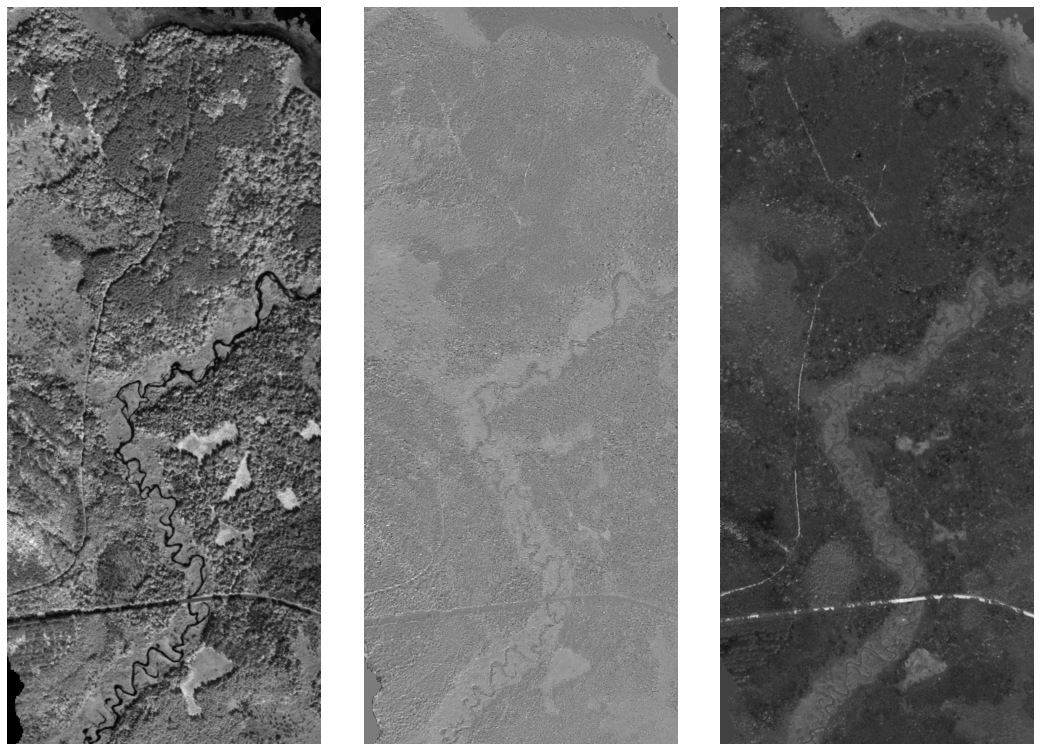

In [ ]:
# Dimentionality reduction using PCA
from spectral import *

pca = principal_components(hsi_img)
pca_999 = pca.reduce(fraction=0.995)
hsi_999 = pca_999.transform(hsi_img)

print(len(pca_999.eigenvalues))
hsi_999 = hsi_999.real
hsi_3com = np.dstack(([hsi_999[:,:,0], hsi_999[:,:,1], hsi_999[:,:,2]]))

# Plot results
fig, ax = plt.subplots(1, 3, figsize=(15,15))
ax[0].imshow((hsi_3com[:,:,0]), cmap=plt.cm.gray)
ax[1].imshow((hsi_3com[:,:,1]), cmap=plt.cm.gray)
ax[2].imshow((hsi_3com[:,:,2]), cmap=plt.cm.gray)
fig.tight_layout()
for ax in ax.ravel():
    ax.axis("off")
plt.show()


In [ ]:
from skimage.segmentation import *
from skimage import color

# Prepare image for segmentation input

seg_in = exposure.rescale_intensity(hsi_3com, out_range=(0,255))
# seg_in = exposure.rescale_intensity(rgb_img, out_range=(0,255))

# Implement image segmentation
segments = quickshift(seg_in, ratio=1.0, kernel_size=5, max_dist=10, return_tree=False,
                         sigma=0.8, convert2lab=False, random_seed=42)
segment_ids = np.unique(segments)
print("Number of segmens: %i segments." % len(segment_ids))

# segments = felzenszwalb(seg_in, scale=1, sigma=0.8, min_size=20)

#Calculate the mean of object in the segmented image
segments_rgb = color.label2rgb(segments, rgb_img, kind='avg')

# Plot the segmented results
fig, axes = plt.subplots(1,3, figsize=(15, 15))
ax = axes.ravel()
ax[0].imshow(rgb_img)
ax[0].set_title('Original image')
ax[1].imshow(mark_boundaries(rgb_img, segments, mode='subpixel', outline_color=(1, 1, 0),))
ax[1].set_title('Segmented image')
ax[2].imshow(segments_rgb)
ax[2].set_title('Mean spectra image')
fig.tight_layout()
for ax in ax.ravel():
    ax.axis("off")
plt.show()

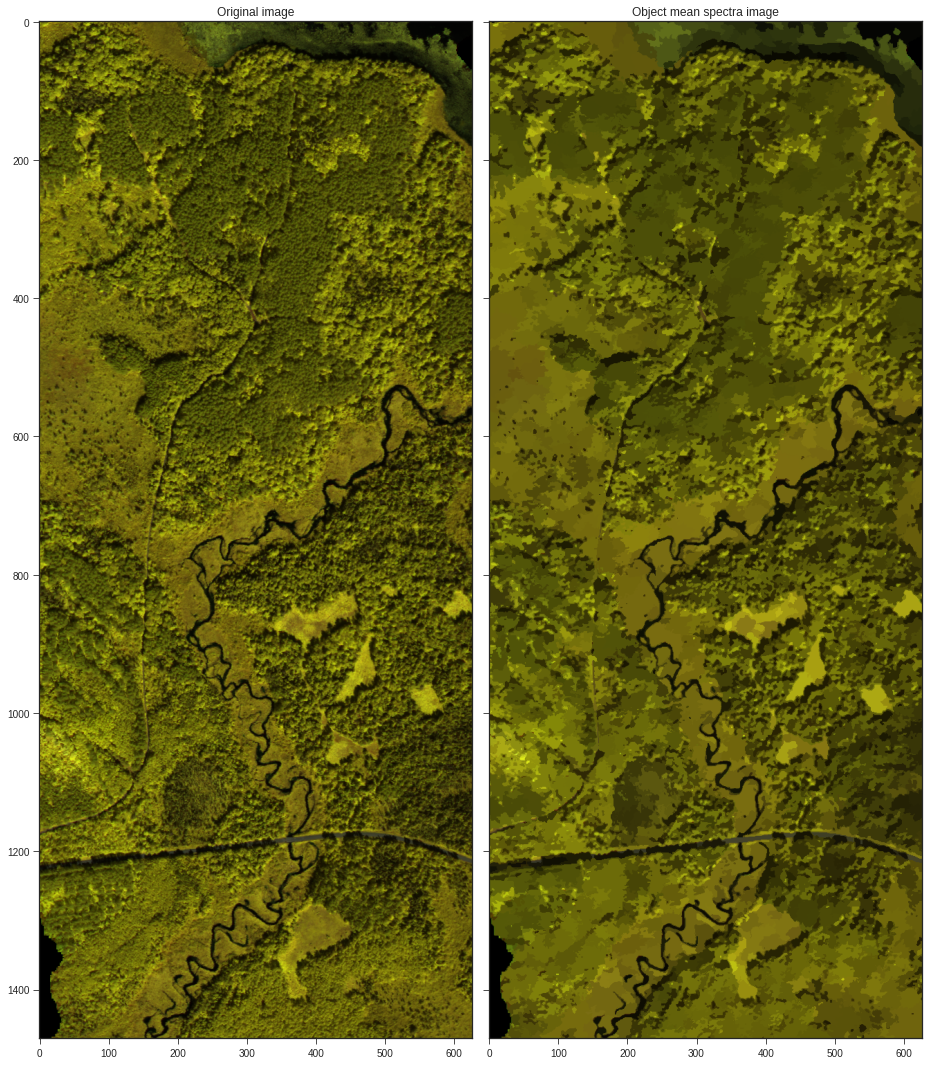

Writing GeoArray of size (1471, 626, 251) to /content/gdrive/My Drive/Colab Notebooks/Species_classification_Eliceo/results/mean_spectra.


In [ ]:
# Calculate the mean spectra of each image segment
from geoarray import GeoArray

hsi_img = GeoArray(hsi_img, geotransform=geo_transform, projection=proj)
hsi_img.bandnames = list(x_ml.columns)

hsi_img_in = hsi_img
n_band = hsi_img.shape[2]
for band in range(n_band):
  hsi_img_in[:,:,band] = label2gray_avg(segments, hsi_img[:,:,band])

# Display RGB image
rgb_img_mean = np.dstack([hsi_img_in[:, :, 180], hsi_img_in[:, :, 120], hsi_img_in[:, :, 55]])
rgb_img_mean = exposure.rescale_intensity(rgb_img_mean, out_range=(0,1))

# Plot the mean spectra image
fig, axes = plt.subplots(ncols=2, figsize=(13, 13), sharey=True)
ax = axes.ravel()
ax[0].imshow(rgb_img)
ax[0].set_title('Original image')
ax[1].imshow(rgb_img_mean)
ax[1].set_title('Object mean spectra image')
fig.tight_layout()
plt.show()

# Save the image to a TIFF file
hsi_img_in_geo = GeoArray(hsi_img_in, geotransform=geo_transform, projection=proj)

hsi_img_in_geo.save(str(out_dir/'mean_spectra'), fmt='GTiff', creationOptions = ["WRITE_METADATA=YES"])

In [ ]:
# Perform hyperspectral image classification
import os
import joblib
import pickle
from pylab import *
plt.style.use('seaborn-ticks')

# Load the pickled model
model_path_mlp = out_dir/'mlp_model.pkl' 
mlp_classifier =  joblib.load(open(model_path_mlp, 'rb'))

# Load the scaler
# scaler = joblib.load(open(out_dir/'scaler.pkl', 'rb'))

hsi_img_in = hsi_img/10000

n_row, n_col, n_band = hsi_img_in.shape
classified_img = np.empty(shape=(n_row, n_col), dtype='uint8')
for i in np.arange(n_row):
  for j in np.arange(n_col):
    # x_ml_tran = pd.DataFrame(hsi_img_in[i,j,:])
    # x_scaled = x_ml_tran.T
    classified_img[i,j] = mlp_classifier.predict(hsi_img_in[i,j,:].reshape(1,-1))
    # classified_img[i,j] = mlp_classifier.predict(scaler.transform(hsi_img_in[i,j,:].reshape(1,-1)))

# Plot the classified image
color_map = plt.cm.get_cmap('RdYlGn', 22)
bar_tick = list(range(0, 22))
plt.figure(figsize=(15, 15))
img_plt = plt.imshow(classified_img, interpolation='none', cmap=color_map) #plt.cm.Greens, plt.cm.YlGn, plt.cm.get_cmap('Greens', 9)
plt.title(os.path.splitext(os.path.basename(img_fn))[0], fontsize=18)
cbar = plt.colorbar(img_plt, ticks=bar_tick)
cbar.set_label(label="Species", size=18)
cbar.ax.tick_params(labelsize=15, rotation=0)
cbar.ax.set_yticklabels(labels=species_name, va="center")
plt.xticks(ticks=[], labels=None)
plt.yticks(ticks=[], labels=None)
plt.grid(b=None)
plt.savefig(out_dir/'mlp_classification_map.png', dpi=500)
plt.show()

# Export classification results to GeoTIFF
prj = raster_dataset.GetProjection()
geotran = raster_dataset.GetGeoTransform()
save_raster(path=str(out_dir/'mlp_classification.tif'), img = classified_img, prj=prj, geotran=geotran, format='GTiff', dtype=gdal.GDT_Byte)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitte

In [ ]:
# The End ----------------------------------------------------------------------